This notebook is designed to run in a IBM Watson Studio default runtime (NOT the Watson Studio Apache Spark Runtime as the default runtime with 1 vCPU is free of charge). Therefore, we install Apache Spark in local mode for test purposes only. Please don't use it in production.

In case you are facing issues, please read the following two documents first:

https://github.com/IBM/skillsnetwork/wiki/Environment-Setup

https://github.com/IBM/skillsnetwork/wiki/FAQ

Then, please feel free to ask:

https://coursera.org/learn/machine-learning-big-data-apache-spark/discussions/all

Please make sure to follow the guidelines before asking a question:

https://github.com/IBM/skillsnetwork/wiki/FAQ#im-feeling-lost-and-confused-please-help-me


If running outside Watson Studio, this should work as well. In case you are running in an Apache Spark context outside Watson Studio, please remove the Apache Spark setup in the first notebook cells.

In [5]:
import os

# Set spark environments
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/usr/bin/python3'
os.environ['JAVA_HOME'] = '/usr/'

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if ('sc' in locals() or 'sc' in globals()):
    printmd('<<<<<!!!!! It seems that you are running in a IBM Watson Studio Apache Spark Notebook. Please run it in an IBM Watson Studio Default Runtime (without Apache Spark) !!!!!>>>>>')


In [6]:
#!pip install pyspark==2.4.5

In [7]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

In [8]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

# Exercise 3.1
Welcome to Exercise 3. 

Now it is time to grab a PARQUET file and create a dataframe out of it. Using SparkSQL you can handle it like a database. 

In [9]:
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2020-10-16 09:25:55--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2020-10-16 09:25:56--  https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet [following]
--2020-10-16 09:25:57--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.c

In [10]:
df = spark.read.parquet('washing.parquet')


So let's check how may rows we have got

In [11]:
df.count()

2058

Now we register the data frame in the ApacheSparkSQL catalog so that we can query it using SQL

In [13]:
df.createOrReplaceTempView("washing")
spark.sql("SELECT flowrate, frequency, temperature FROM washing").show()

+--------+---------+-----------+
|flowrate|frequency|temperature|
+--------+---------+-----------+
|      11|     null|        100|
|    null|     null|       null|
|    null|       71|       null|
|      11|     null|         86|
|    null|       75|       null|
|    null|     null|       null|
|      11|     null|         84|
|      11|     null|         84|
|    null|       73|       null|
|      11|     null|         96|
|      11|     null|         88|
|    null|     null|       null|
|    null|       80|       null|
|      11|     null|         87|
|    null|       62|       null|
|    null|       61|       null|
|      11|     null|         96|
|      11|     null|         90|
|      11|     null|         88|
|      11|     null|         80|
+--------+---------+-----------+
only showing top 20 rows



So let's visualize voltage using a box plot to get an idea on the value distribution of this parameter. First, we have to create a python list. Make sure you use the sample function in order to not blast your spark driver or plotting library. 

In [14]:
result = spark.sql("select voltage from washing where voltage is not null")
result_array = result.rdd.map(lambda row : row.voltage).sample(False,0.1).collect()

#just print the 1st 15 elements
result_array[:15]

[235, 225, 224, 223, 228, 232, 229, 226, 230, 221, 223, 230, 235, 235, 220]

Now we have to activate the notebook to show the plots directly under the cell

In [15]:
%matplotlib inline

Now it's time to plot the python list by importing the matplotlib library, calling "boxplot" and "show". Note that you can see mean (red line) around 230. Then you see that 50% of all values are between 225 and 235 (blue box). Per default values up to 250 are not seen as outliers (little, black horizontal line). And the "plus" symbols on top are definitely outliers. Congratulations, you've written your first anomaly detection algorithm. Unfurtunately you still need a brain attached to it, so we'll cover on how we write one without a brain needed in the next course. And in the course after that we'll even tell you how to implement a artificial brain to further improve it, so stay tuned :)

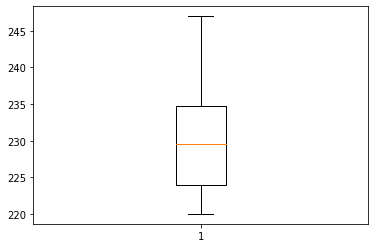

In [16]:
import matplotlib.pyplot as plt
plt.boxplot(result_array)
plt.show()

Since we are dealing with time series data we want to make use of the time dimension as well. The least complex plots are run charts where the time domain (dimension) is represented at the horizontal x-axis and the y-axis shows the actual sensor value. Let's do this for voltage as well. 

In [19]:
result = spark.sql("select voltage,ts from washing where voltage is not null order by ts asc")
result_rdd = result.rdd.sample(False,0.1).map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()
print(result_array_ts[:15])
print(result_array_voltage[:15])

[1547808728916, 1547808749929, 1547808776948, 1547808864037, 1547808903087, 1547808915092, 1547808924097, 1547808954133, 1547808966142, 1547808978152, 1547808984163, 1547809020199, 1547809050217, 1547809095246, 1547809107251]
[222, 225, 235, 235, 220, 238, 225, 236, 221, 228, 229, 221, 234, 237, 220]


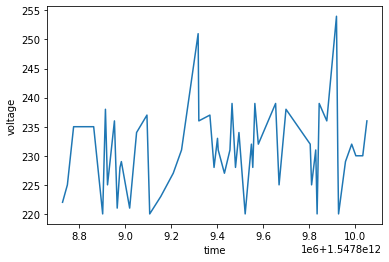

In [20]:
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

But this time we want to only plot data worth of one hour. Therefore we first have to find out in which date range we have data available:

In [21]:
spark.sql("select min(ts),max(ts) from washing").show()

+-------------+-------------+
|      min(ts)|      max(ts)|
+-------------+-------------+
|1547808720911|1547810064867|
+-------------+-------------+



Now lets repeat the previous steps but only show data for hour. We've found out the low and high boundary of data available and we know that "ts" stand for "timestamp". Timestamp are the number of millisecons passed since the 1st of Jan. 1970. You can also use an online tool like http://www.epochconverter.com/ to convert these. But for now just an interval of 60 minutes (1000*60*60)=3600000 within the range above (note that we have removed the sample function because the data set is already reduced)

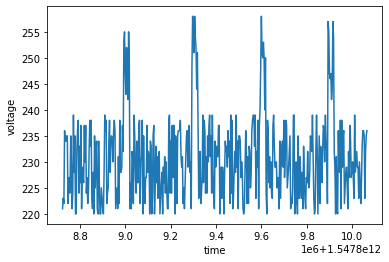

In [22]:
result = spark.sql(
"""
select voltage,ts from washing 
    where voltage is not null and 
    ts > 1547808720911 and
    ts <= 1547810064867+3600000
    order by ts asc
""")
result_rdd = result.rdd.map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

As you can see we are not only able to spot the outliers but also see a time pattern of these outliers occuring which can be used for further downstream analysis. Again your brain was already capable of spotting the pattern. In the next two coursera courses we will teach a machine to spot those patterns as well.

Now we've plotted a maximum of two dimensions at a time, let's go for three in a so-called 3D scatter plot. Again we have to create python lists (with applied sampling if necessary) from three properties of our data.

In [23]:
result_df = spark.sql("""
select hardness,temperature,flowrate from washing
    where hardness is not null and 
    temperature is not null and 
    flowrate is not null
""")
result_rdd = result_df.rdd.sample(False,0.1).map(lambda row : (row.hardness,row.temperature,row.flowrate))
result_array_hardness = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[0]).collect()
result_array_temperature = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[1]).collect()
result_array_flowrate = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[2]).collect()

Once done it is very simple to import the necessary library and create a scatter plot

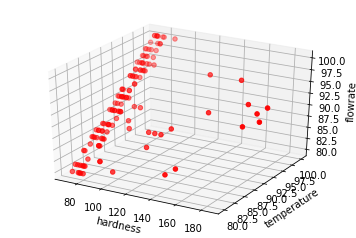

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_array_hardness,result_array_temperature,result_array_flowrate, c='r', marker='o')

ax.set_xlabel('hardness')
ax.set_ylabel('temperature')
ax.set_zlabel('flowrate')

plt.show()

You will notice that the individual points resemble in some sort of plane. But this is not a surprise. Actually we can draw the following conclusions from the plot:

- most of the data points are lying around hardness 60-80, temperature 80-100 and flowrate 80-100
- there are some outliers, especially when it comes to the range of hardness 100-200
- the data follows some narrow boundaries

So lets double-check what's going on with hardness since it seems that it really sticks around 60-80 and very seldom creates values above that. We can use a histogram for that which bins together certain value ranges and counts the frequency of occurences of values within this range. Those frequencies are ordered and shown as a bar diagram, so let's plot it:

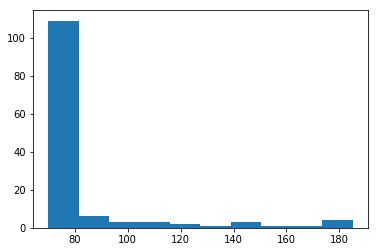

In [25]:
plt.hist(result_array_hardness)
plt.show()

Our assumpion was correct, nearly all values are around 60-80 with very less values about that threshold.
This concludes Exercice 3.1.